In [11]:
import sys
import os
import re
import subprocess
import imagehash
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import random
import shutil
import numpy as np
import tensorflow as tf
from PIL import Image

warnings.filterwarnings("ignore")


2023-12-05 16:11:29.867784: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 16:11:30.008986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 16:11:30.009020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 16:11:30.033083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 16:11:30.085603: I tensorflow/core/platform/cpu_feature_guar

https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset/  
https://universe.roboflow.com/new-workspace-mujgg/yoga-pose

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-12-05 16:11:36.550886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 16:11:36.657594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 16:11:36.657709: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
from PIL import Image

def download_images():

    file_list = os.listdir('../data/Yoga-82/yoga_dataset_links')
    success = 0
    fail = 0
    
    for i in range(len(file_list)):
        f = open("../data/Yoga-82/yoga_dataset_links/" + file_list[i], 'r');
        lines = f.readlines();
        f.close();

        for j in range(len(lines)):
            splits = lines[j][:len(lines[j])-1].split("\t")
            img_path = splits[0]
            link = splits[1]
    
            folder_name, img_name = img_path.split("/")
            folder_name = re.sub(r'[^a-zA-Z0-9_]', '', folder_name)
            if(j == 0):
                if(not os.path.isdir("../data/DownloadedImages/" + folder_name)):
                    os.mkdir("../data/DownloadedImages/" + folder_name)

            download_command = ['wget', '--timeout=2', '--tries=1', '--quiet', '-O', f'../data/DownloadedImages/{folder_name}/{img_name}', link]
            
            try:
                subprocess.run(download_command, check=True, stderr=subprocess.DEVNULL)
                try:
                    img = Image.open('../data/DownloadedImages/' + folder_name + '/' + img_name)
                    success+=1
                except:
                    fail+=1
            except:
                fail+=1
                
    return success, fail

#success, fail = download_images()
#print (f'{success} images downloaded, {fail} failures')

19374 images downloaded, 9076 failures


In [3]:
def remove_invalid_images(directory):
    
    removed = 0
    hash_dict = {}
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            if os.path.getsize(file_path) == 0:
                os.remove(file_path)
                removed+=1
                continue
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception:
                os.remove(file_path)
                removed+=1
                continue
            
            try:
                with Image.open(file_path) as img:
                    img_hash = imagehash.phash(img)
                    if img_hash in hash_dict:
                        os.remove(file_path)
                        removed+=1
                    else:
                        hash_dict[img_hash] = file_path
            except (OSError, Image.DecompressionBombError) as e:
                print(f'Error processing image {file_path}: {e}')
            
    return removed

#directory = '../data/DownloadedImages/'
#removed = remove_invalid_images(directory)
#print(f'{removed} invalid images')

Error processing image ../data/DownloadedImages/Side_Plank_Pose_or_Vasisthasana_/498.jpg: image file is truncated (0 bytes not processed)
9329 invalid images


In [7]:
def clean_dir_names(directory):

    for root, dirs, files in os.walk(directory):
        for directory in dirs:
            original_path = os.path.join(root, directory)
            new_directory = directory.replace(' ', '_')
            new_directory = new_directory.rstrip('_')
            new_path = os.path.join(root, new_directory)
            os.rename(original_path, new_path)

#directory = '../data/DownloadedImages/'
#clean_dir_names(directory)

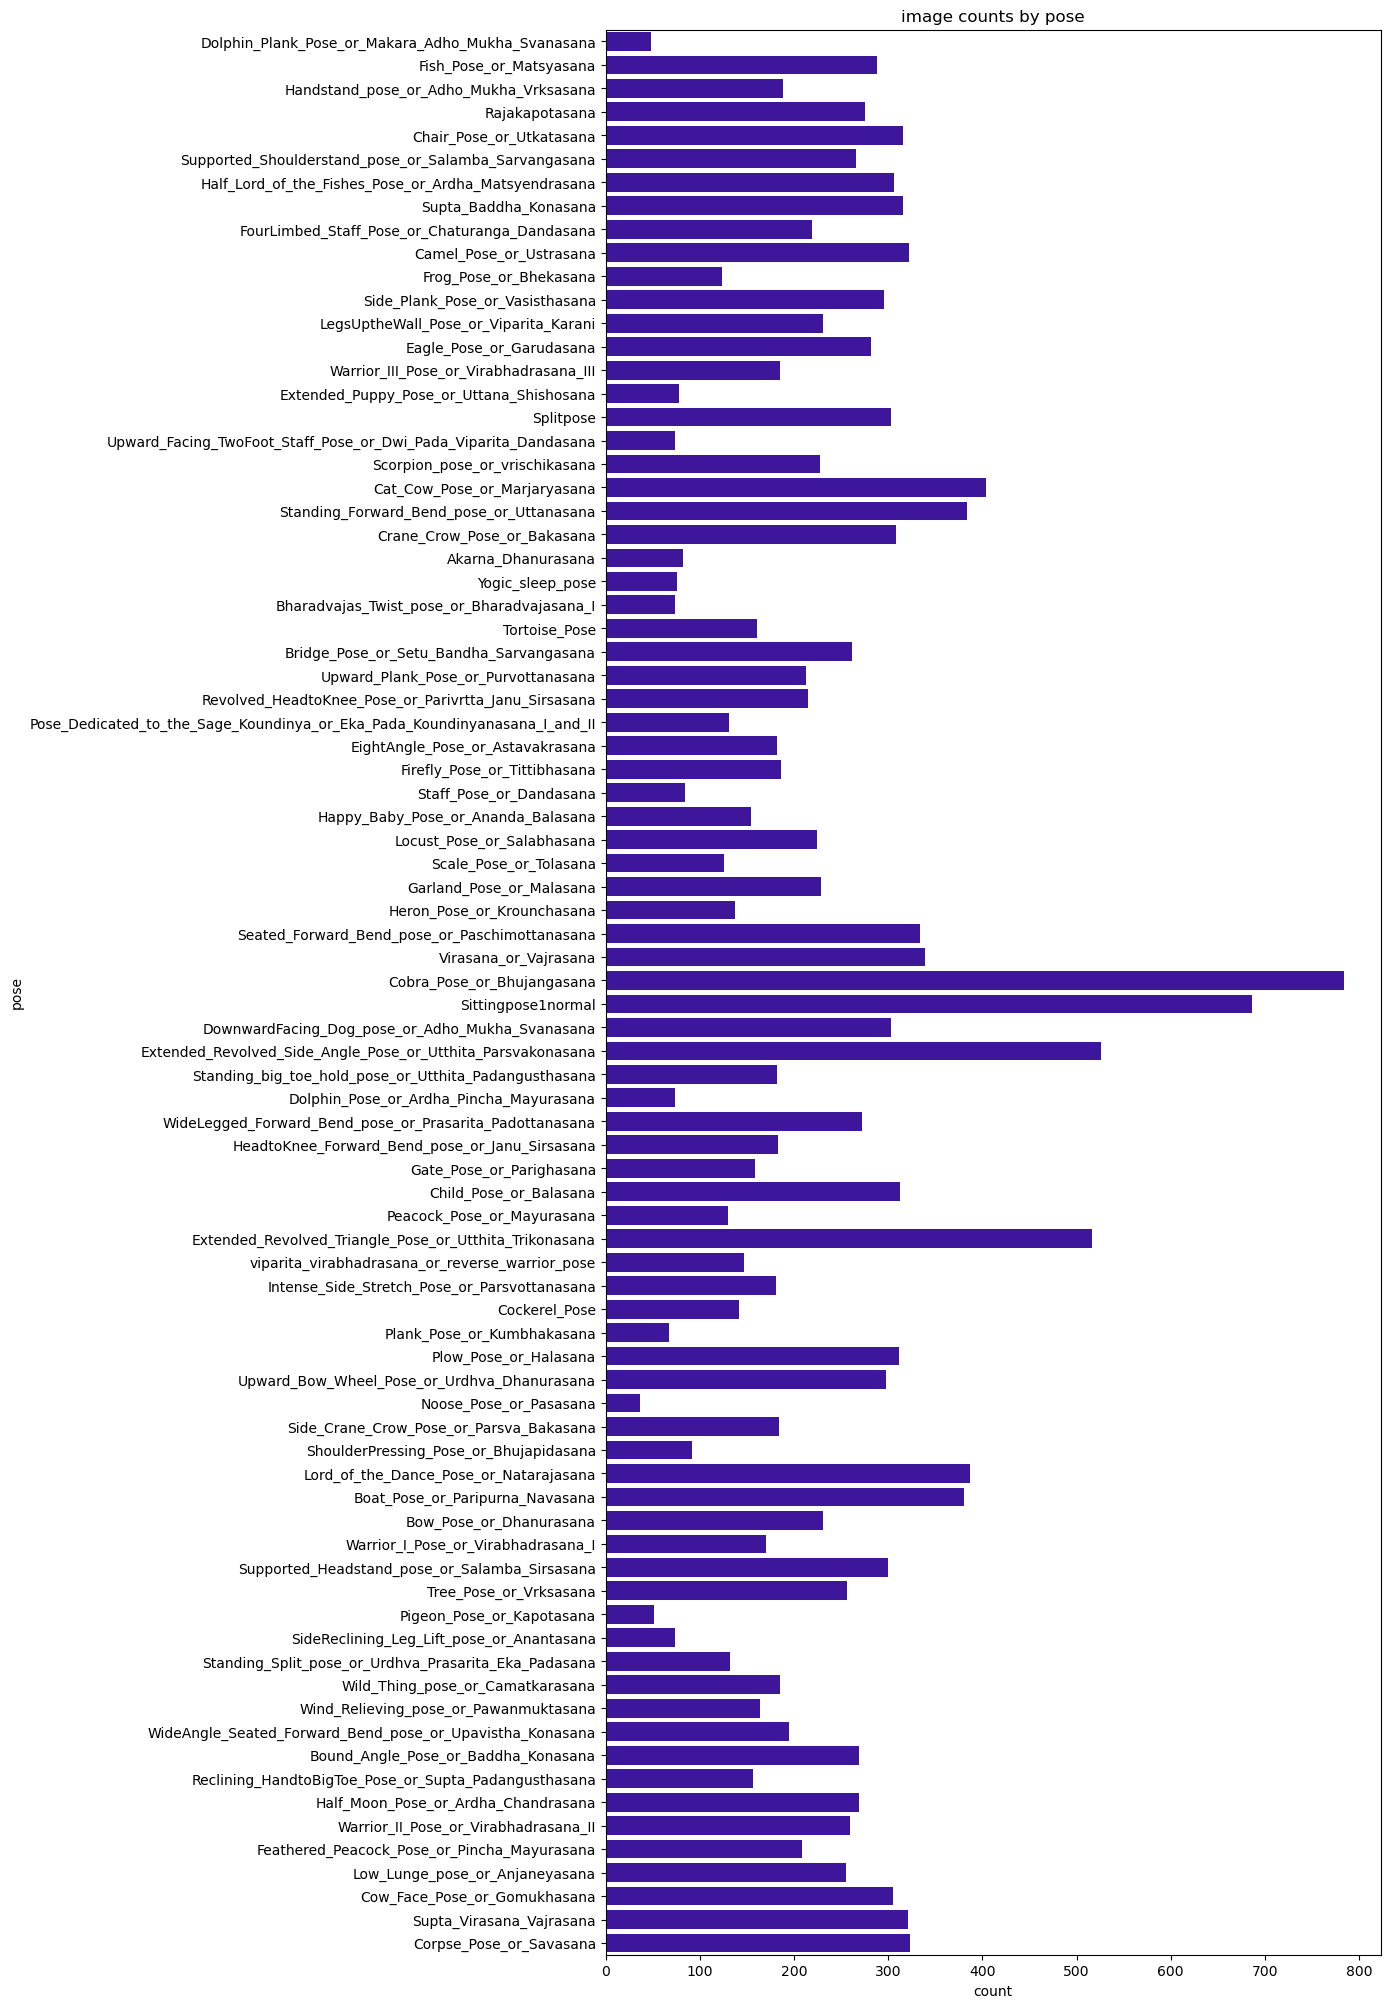

In [9]:
pose_counts = {}

for root, dirs, files in os.walk('../data/DownloadedImages/'):
    folder_name = os.path.basename(root)  
    if folder_name:
        pose_counts[folder_name] = len(files)

pose_counts = pd.DataFrame({'pose': list(pose_counts.keys()), 
                            'count': list(pose_counts.values())})
plt.figure(figsize=(10, 25)) 
sns.barplot(x='count', 
            y='pose', 
            data=pose_counts,
            color=(0.2, 0, 0.7)
           )

plt.title('image counts by pose')
plt.show()


In [16]:
def create_train_val_test_sets(root_directory, 
                               train_dir, 
                               val_dir, 
                               test_dir, 
                               holdout_size=10):
    
    for label in os.listdir(root_directory):
        label_path = os.path.join(root_directory, label)
        
        if os.path.isdir(label_path):
            images = os.listdir(label_path)

            if len(images) <= holdout_size * 2:
                print(f"Skipping {label} due to insufficient images.")
                continue
            
            random.shuffle(images)
            test_images = images[:holdout_size]
            remaining_images = images[holdout_size:]
            val_images = remaining_images[:holdout_size]
            train_images = remaining_images[holdout_size:]

            for directory in [train_dir, val_dir, test_dir]:
                label_dest_path = os.path.join(directory, label)
                if not os.path.exists(label_dest_path):
                    os.makedirs(label_dest_path)
            
            for img_name in val_images:
                src_path = os.path.join(label_path, img_name)
                dest_path = os.path.join(val_dir, label, img_name)
                shutil.copy(src_path, dest_path)
                
            for img_name in test_images:
                src_path = os.path.join(label_path, img_name)
                dest_path = os.path.join(test_dir, label, img_name)
                shutil.copy(src_path, dest_path)
                
            for img_name in train_images:
                src_path = os.path.join(label_path, img_name)
                dest_path = os.path.join(train_dir, label, img_name)
                shutil.copy(src_path, dest_path)

root_directory = '../data/DownloadedImages' 
train_directory = '../data/splits/train' 
val_directory = '../data/splits/validate' 
test_directory = '../data/splits/test'  

create_train_val_test_sets(root_directory, 
                           train_directory, 
                           val_directory, 
                           test_directory
                          )


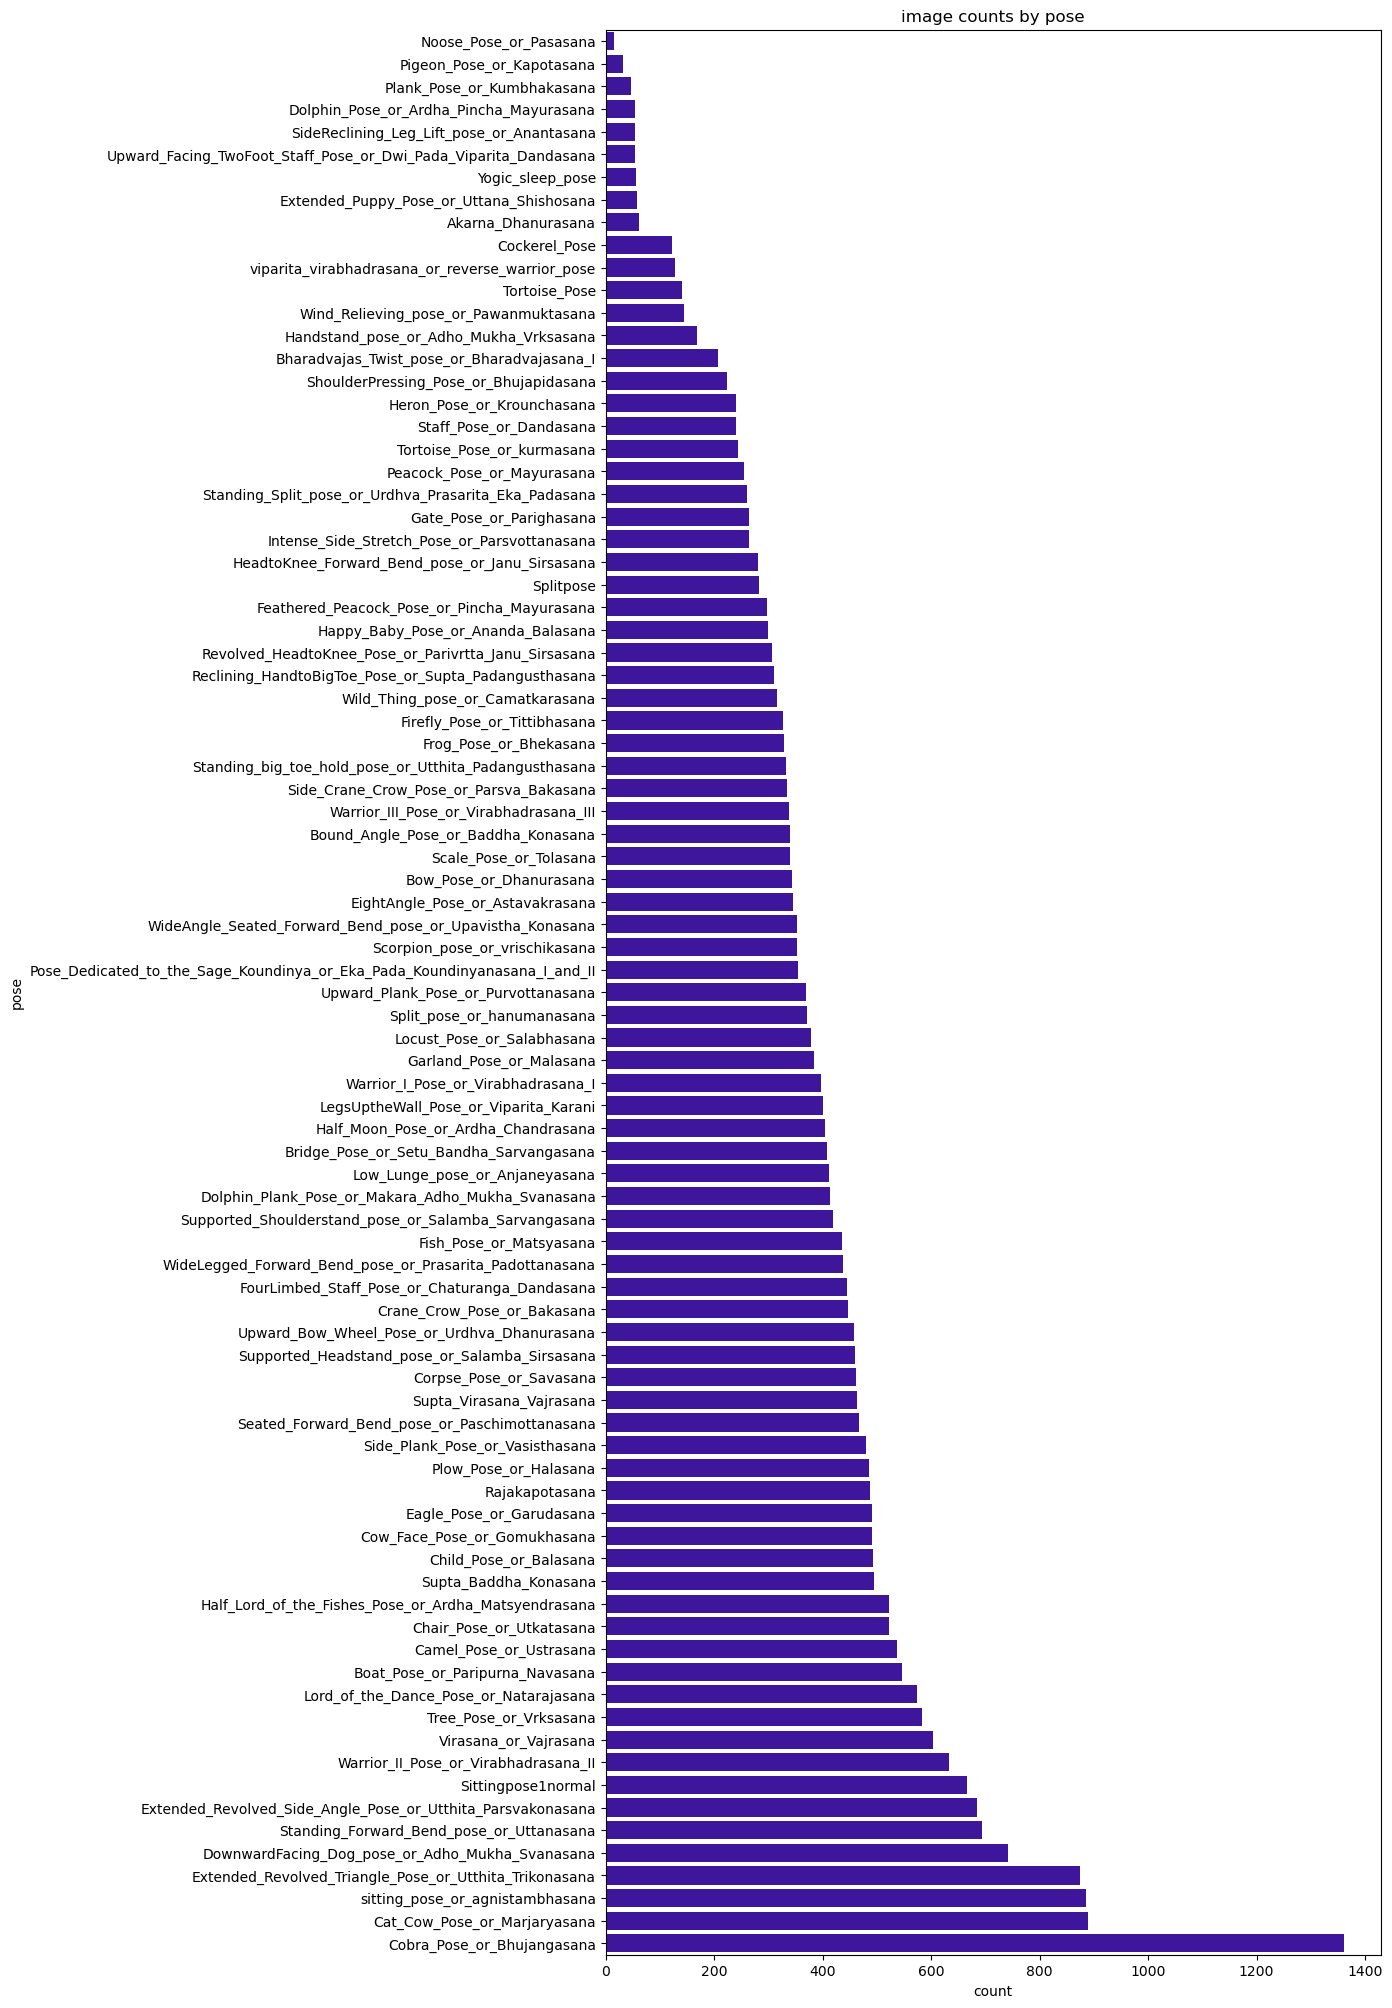

In [17]:
def count_pose_images(root_directory):
    pose_counts = {}

    for root, dirs, files in os.walk(root_directory):
        folder_name = os.path.basename(root)  
        if folder_name == os.path.basename(root_directory):
            continue
        if folder_name:
            pose_counts[folder_name] = len(files)

    return dict(sorted(pose_counts.items(), key=lambda item: item[1]))

def plot_pose_counts(pose_counts):
    pose_counts = pd.DataFrame({'pose': list(pose_counts.keys()), 
                                'count': list(pose_counts.values())})
    plt.figure(figsize=(10, 25)) 
    sns.barplot(x='count', 
                y='pose', 
                data=pose_counts,
                color=(0.2, 0, 0.7)
               )

    plt.title('image counts by pose')
    plt.show()

root_directory = '../data/splits/train'  # Replace this with your actual root directory
pose_counts = count_pose_images(root_directory)
plot_pose_counts(pose_counts)


In [19]:
def drop_sparse_labels(directory, min_count=200):
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        if os.path.isdir(label_path):
            image_count = len(os.listdir(label_path))

        if image_count < min_count:
            print(f"deleting {label} with {image_count} images.")
            shutil.rmtree(label_path)

directory = '../data/splits/train'  # Replace this with your actual root directory
min_image_count = 200
drop_sparse_labels(root_directory, min_image_count)

deleting Extended_Puppy_Pose_or_Uttana_Shishosana with 58 images.
deleting Cockerel_Pose with 122 images.
deleting Upward_Facing_TwoFoot_Staff_Pose_or_Dwi_Pada_Viparita_Dandasana with 54 images.
deleting Pigeon_Pose_or_Kapotasana with 31 images.
deleting viparita_virabhadrasana_or_reverse_warrior_pose with 127 images.
deleting Handstand_pose_or_Adho_Mukha_Vrksasana with 168 images.
deleting Tortoise_Pose with 141 images.
deleting Plank_Pose_or_Kumbhakasana with 47 images.
deleting Noose_Pose_or_Pasasana with 16 images.
deleting Dolphin_Pose_or_Ardha_Pincha_Mayurasana with 53 images.
deleting Yogic_sleep_pose with 56 images.
deleting Wind_Relieving_pose_or_Pawanmuktasana with 144 images.
deleting SideReclining_Leg_Lift_pose_or_Anantasana with 53 images.
deleting Akarna_Dhanurasana with 62 images.


In [3]:
root_directory = '../data/splits/train'
class_folders = os.listdir(root_directory)

images = []
labels = []

for class_folder in class_folders:
    class_path = os.path.join(root_directory, class_folder)

    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img = Image.open(image_path)
        img_array = np.array(img)

        images.append(img_array)
        labels.append(class_folder)

In [ ]:
root_directory = '../data/splits/train'  
pose_counts = count_pose_images(root_directory)

seq = iaa.Sequential([
    #iaa.Fliplr(0.5),        # Horizontal flips
    iaa.Affine(rotate=(-179, 179)),  
    iaa.Multiply((0.7, 1.3), per_channel=0.2),
    iaa.GaussianBlur(sigma=(0, 1.0)) 
])

augmented_images = []
augmented_labels = []

for image, label in zip(images, labels):
    # Apply data augmentation for classes with less than 1000 examples
    if pose_counts[label] < 1000:
        augmented = seq(image=image)
        augmented_images.append(augmented)
        augmented_labels.append(label)

# Randomly remove images from classes with more than 1000 examples
for label, count in pose_counts.items():
    if count > 1000:
        indices_to_keep = random.sample(range(count), 1000)
        selected_images = [images[i] for i in range(len(images)) if labels[i] == label and i in indices_to_keep]
        selected_labels = [label] * len(selected_images)
        augmented_images.extend(selected_images)
        augmented_labels.extend(selected_labels)